# Neural Ordinary Differential Equations wiht adjoint method

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint

### 1. Генерация данных

In [2]:
def generate_spiral_data(num_step=100, noise_level=0.3):
    """Генерация шумных данных спирали"""
    t = torch.linspace(5., 25., num_step)
    x = t * torch.sin(t) + noise_level * torch.randn(t.size())
    y = t * torch.cos(t) + noise_level * torch.randn(t.size())
    return torch.stack((x, y), dim=1), t

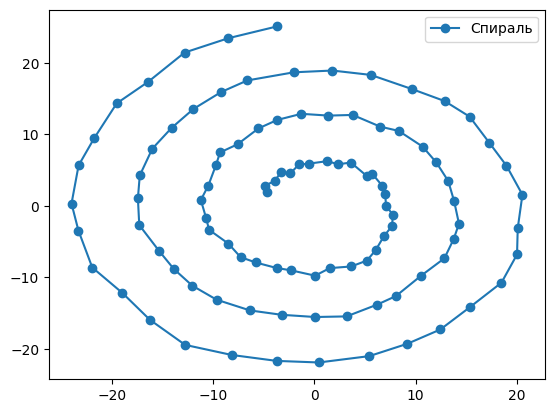

In [3]:
data, times = generate_spiral_data()
input_data = data[:-1]  # Все данные, кроме последнего эл-та
target_data = data[1:]  # смещение target на t=1 относительно входов

plt.figure()
plt.plot(data[:, 0], data[:, 1], label='Спираль', marker='o')
plt.legend()
plt.show()

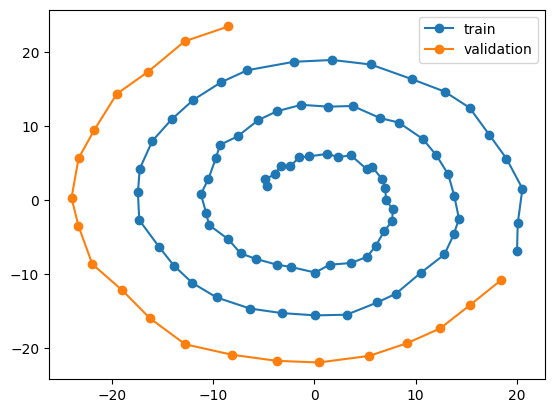

In [4]:
# Train/validation split
split_index = int(len(input_data) * 0.8)

train_data = {
    'input': input_data[:split_index].unsqueeze(1),
    'target': target_data[:split_index].unsqueeze(1),
    'times': times[:split_index]
}

val_data = {
    'input': input_data[split_index:].unsqueeze(1),
    'target': target_data[split_index:].unsqueeze(1),
    'times': times[split_index:]
}

plt.figure()
plt.plot(train_data['input'][:,0, 0], train_data['input'][:, 0, 1], label='train', marker='o')
plt.plot(val_data['input'][:, 0, 0], val_data['input'][:, 0, 1], label='validation', marker='o')
plt.legend()
plt.show()

## 1. Neural ODEs

In [5]:
batch_time = 5
batch_size = 8
train_data_size = train_data['input'].shape[0]

# def get_batch():
#     random_indexes = torch.from_numpy(np.random.choice(np.arange(train_data_size - batch_time, dtype=np.int64), batch_size, replace=False))
#     batch_y0 = train_data['input'][random_indexes]  # (batch_size, 1, emb)
#     batch_t = train_data['times'][:batch_time]  # (T)
    # batch_y = torch.stack([train_data['target'][random_indexes + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
#     return batch_y0, batch_t, batch_y

def get_batch(data, batch_time, batch_size):
    data_size = data['input'].shape[0]
    
    batches = []    
    for i in range(0, data_size - batch_time, batch_size):
                                  
        if i + batch_size > data_size: 
            break
                                  
        y0_beg = i
        y0_end = i + batch_size
        batch_y0 = data['input'][y0_beg:y0_end]
        
        t_beg = i
        t_end = i + batch_time
        batch_t = data['times'][t_beg:t_end] 
        
        batch_y = []
        for index_y0 in range(batch_size):
            y_beg = index_y0 + i
            y_end = index_y0 + batch_time + i
            batch_y.append(data['target'][y_beg:y_end])
        batch_y = torch.stack(batch_y, dim=1)    
        batches.append((batch_y0, batch_t, batch_y))

    return batches

test = {
'input': [1,2,3,4,5,6,7,8,9,10],
'times':[1,2,3,4,5,6,7,8,9,10],
'target':[2,3,4,5,6,7,8,9,10,11]
}
# batches = get_batch(data=test, batch_time=2, batch_size=3)

batches = get_batch(train_data, batch_time, batch_size)
print(len(batches))

9


In [6]:
# 8*9, train_data['input'].shape[0]

In [7]:
for ind in range(len(batches)):
    print(batches[ind][0].shape, batches[ind][1].shape, batches[ind][2].shape)

torch.Size([8, 1, 2]) torch.Size([5]) torch.Size([5, 8, 1, 2])
torch.Size([8, 1, 2]) torch.Size([5]) torch.Size([5, 8, 1, 2])
torch.Size([8, 1, 2]) torch.Size([5]) torch.Size([5, 8, 1, 2])
torch.Size([8, 1, 2]) torch.Size([5]) torch.Size([5, 8, 1, 2])
torch.Size([8, 1, 2]) torch.Size([5]) torch.Size([5, 8, 1, 2])
torch.Size([8, 1, 2]) torch.Size([5]) torch.Size([5, 8, 1, 2])
torch.Size([8, 1, 2]) torch.Size([5]) torch.Size([5, 8, 1, 2])
torch.Size([8, 1, 2]) torch.Size([5]) torch.Size([5, 8, 1, 2])
torch.Size([8, 1, 2]) torch.Size([5]) torch.Size([5, 8, 1, 2])


In [8]:
# define dynamic function
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 50),
                             nn.Tanh(),
                             nn.Linear(50, 2))
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        output = self.net(y)
        return output

### 3. Train

Реализуем сопряженное обратное распространение c использованием пакет torchdiffeq.

Обратное распространение через odeint осуществляется через внутренние компоненты решателя. 

```
from torchdiffeq import odeint_adjoint as odeint
odeint_adjoint(func, y0, t, rtol, atol, method)
```

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch 0000


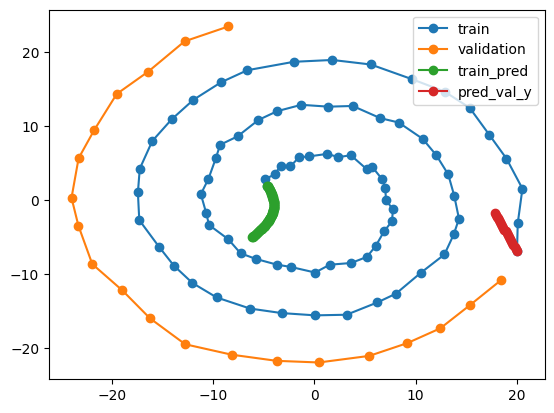

Epoch 0100


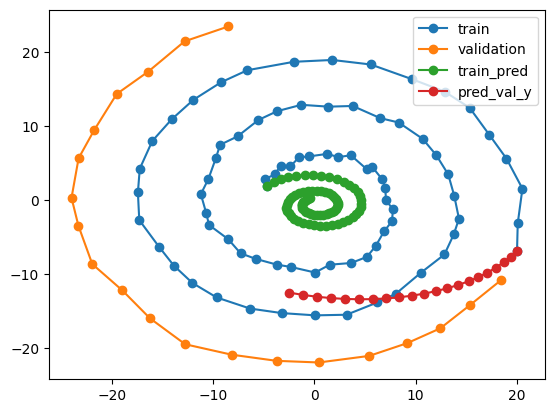

Epoch 0200


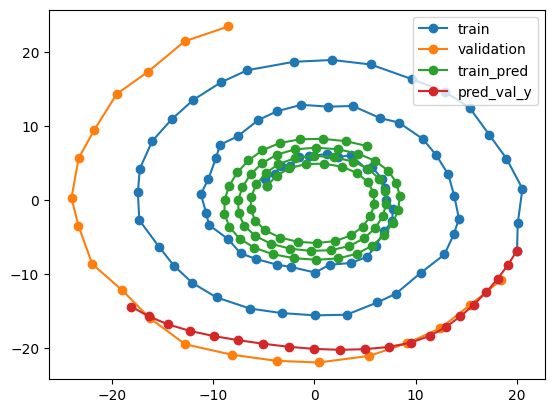

Epoch 0300


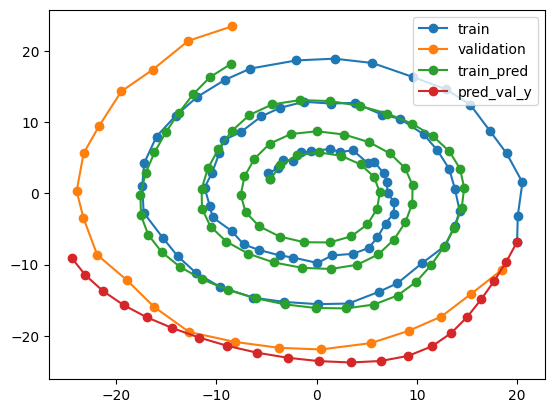

Epoch 0400


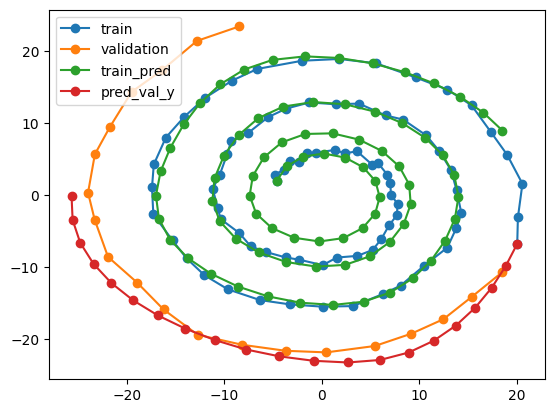

Epoch 0500


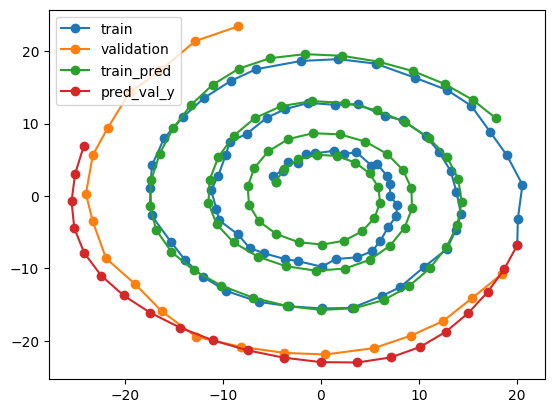

process time: 392.1706864833832 sec


In [11]:
hist_fit_train_loss = []
hist_train_loss = []
hist_val_loss = []

func = ODEFunc()
# optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
optimizer = optim.Adam(func.parameters(), lr=1e-3)

start_time = time.time()

for epoch in tqdm(range(500 + 1)):
    
    optimizer.zero_grad() 
    loss = 0
    for batch in batches: 
        batch_y0, batch_t, batch_y = batch 
        pred_y = odeint_adjoint(func=func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
        loss += torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    hist_fit_train_loss.append(loss.item())
    optimizer.step()
        
    if epoch % 100 == 0:
        with torch.no_grad():
            
            print('Epoch {:04d}'.format(epoch))
            pred_train = odeint_adjoint(func, train_data['input'][0], train_data['times'], rtol=1e-7, atol=1e-9, method='dopri5')
            pred_val_y = odeint_adjoint(func, train_data['input'][-1], val_data['times'], rtol=1e-7, atol=1e-9, method='dopri5') 
    
            plt.figure()
            plt.plot(train_data['input'][:, 0, 0], train_data['input'][:, 0, 1], label='train', marker='o')
            plt.plot(val_data['input'][:, 0, 0], val_data['input'][:, 0, 1], label='validation', marker='o')
            plt.plot(pred_train[:, 0, 0], pred_train[:, 0, 1], label='train_pred', marker='o')
            plt.plot(pred_val_y[:,0, 0], pred_val_y[:, 0, 1], label='pred_val_y', marker='o')
            plt.legend()
            plt.show()

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))